# Imports

In [438]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import random as rand


from keras.utils import to_categorical
from keras.layers import Dense, Activation, Conv2D,Conv2DTranspose, Dropout, Reshape, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization
from keras.models import Sequential, load_model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split

# Parameters

In [439]:
N_EPOCHS = 100
BATCH_SIZE = 32
DATASET_SIZE = 700
TRAIN_DATA_SIZE = int(DATASET_SIZE - (DATASET_SIZE * 0.2))
LATENT_DIM = 128

# Data importing and pre-processing

In [440]:
df = pd.read_csv('dataset.csv', header=None)


df = df.values.reshape(DATASET_SIZE, 64, 64, 1)

x_real_train, x_real_test = train_test_split(df, test_size=0.2)


normalize dataset data into range of sigmoid [0,1], and put into batches

In [441]:
x_real_train = x_real_train.astype('float32')
x_real_train /=255


training_data = tf.data.Dataset.from_tensor_slices(x_real_train).shuffle(TRAIN_DATA_SIZE).batch(BATCH_SIZE)

Visualise random example from dataset

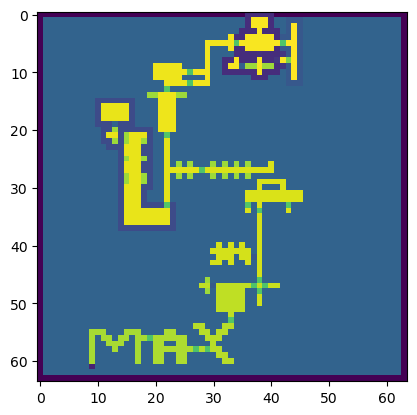

In [442]:
plt.imshow(df[rand.randint(0,DATASET_SIZE)])

# Generator Model

Create points in latent space to be fed into generator

In [443]:
def generate_generator_input(no_of_maps):
    input = tf.random.normal(shape=(no_of_maps, LATENT_DIM))
    
    return input

In [444]:
def make_generator():
    model = Sequential()
    
    model.add(Dense(LATENT_DIM*8*8, input_shape=(LATENT_DIM,)))

    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((8,8,LATENT_DIM)))

    
    
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(8,8,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dropout(0.2))
    
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(16,16,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(32,32,60)))
    model.add(LeakyReLU())

    model.add(Dropout(0.2))

    model.add(Conv2DTranspose(1, kernel_size=5, padding="same"))
    model.add(Activation("sigmoid"))
    
              
    model.summary()
    
    return model
    
    

# Discriminator Model

In [445]:

def make_discriminator():
    
    # 1st set of layers
    model = Sequential()
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same", input_shape=(64,64,1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    

    model.add(Conv2D(32, kernel_size=4, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    
    '''
    model.add(Conv2D(16, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    '''
    
    model.add(Dense(100, activation='relu'))
    #model.add(Activation='relu')
    
    # output layer
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(1)) # Binary classification (2 outputs), so only 1 dense layer needed
    model.add(Activation('sigmoid'))
    
    model.summary()
    return model
    

Create the models from the functions

In [446]:
gen_model = make_generator()

disc_model = make_discriminator()


Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 8192)              1056768   
                                                                 
 batch_normalization_104 (B  (None, 8192)              32768     
 atchNormalization)                                              
                                                                 
 leaky_re_lu_156 (LeakyReLU  (None, 8192)              0         
 )                                                               
                                                                 
 reshape_26 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_104 (Conv  (None, 16, 16, 128)       262144    
 2DTranspose)                                                    
                                                     

Next, test the untrained discriminator on the map of noise generated before

Negative values means fake, positive means real

## Loss and Optimizers

In [447]:
cross_entropy = BinaryCrossentropy(from_logits=True)



Discriminator loss, taken from: https://www.tensorflow.org/tutorials/generative/dcgan

In [448]:
def discrim_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss

In [449]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Optimizers:

In [450]:
gen_optimizer = Adam(learning_rate =0.0001, beta_1=0.4)
disc_optimizer = Adam(learning_rate =0.0001, beta_1=0.4)

Discriminator accuracy

In [451]:
def compute_discrim_accuracy(disc_output, expected):

    disc_output = disc_output[0].tolist()
    
    if int(np.round(0,float(disc_output))) == expected:
        accuracy = 1
    else:
        accuracy = 0

    return accuracy


## Training

Training step

In [452]:
@tf.function
def training_step(current_batch):
    
    noise_sample = generate_generator_input(BATCH_SIZE)
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_map = gen_model(noise_sample, training=True)
        print("generated map shape" + str(generated_map.shape))
        
        fake_output = disc_model(generated_map,  training=True)
        real_output = disc_model(current_batch, training=True)
        
        

        gen_loss = generator_loss(fake_output=fake_output)
        disc_loss = discrim_loss(real_output=real_output, fake_output=fake_output)



    #fake_accuracy = compute_discrim_accuracy(fake_output, 0)
    #real_accuracy = compute_discrim_accuracy(real_output, 1)

    #disc_accuracy = (fake_accuracy + real_accuracy) / 2    

    gen_gradients = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, disc_model.trainable_variables))

    return gen_loss, disc_loss

Train models

In [453]:
def train(dataset, N_EPOCHS):

    gen_losses = []
    disc_losses = []

    disc_accuracies = []
    
    img_seed = generate_generator_input(1)

    for epoch in range(N_EPOCHS):
        gen_losses_for_epoch = []
        disc_losses_for_epoch = []

        disc_accuracies_for_epoch = []

        print("epoch = " + str(epoch))

        for map_batch in dataset:
            
            
            gen_loss, disc_loss = training_step(map_batch)

            gen_losses_for_epoch.append(gen_loss)
            disc_losses_for_epoch.append(disc_loss)
           # disc_accuracies.append(disc_accuracy)
        
        avg_gen_loss = sum(gen_losses_for_epoch) / TRAIN_DATA_SIZE
        avg_disc_loss = sum(disc_losses_for_epoch) / TRAIN_DATA_SIZE

        #avg_disc_accuracy = sum(disc_accuracies_for_epoch) / TRAIN_DATA_SIZE

        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        #disc_accuracies.append(avg_disc_accuracy)

        print("Gen loss = " + str(avg_gen_loss) + "Disc loss = " + str(avg_disc_loss))
              
        #print("Disc accuracy = " + str(avg_disc_accuracy))
# generate and show a map after 10 epochs

        if epoch % 10 == 0:
            
            generated_map = gen_model(img_seed, training=False)
            generated_map *= 255
            generated_map = generated_map.numpy()
            generated_map.reshape(64,64)
            generated_map = np.round(generated_map,0)
            generated_map = generated_map.tolist()
            plt.imshow(generated_map[0])
            plt.show()
    
    
    generated_map = gen_model(img_seed, training=False)

    

    return gen_losses, disc_losses, generated_map


Train GAN

epoch = 0
generated map shape(32, 64, 64, 1)


/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


generated map shape(32, 64, 64, 1)
generated map shape(32, 64, 64, 1)
Gen loss = tf.Tensor(0.02297362, shape=(), dtype=float32)Disc loss = tf.Tensor(0.040902324, shape=(), dtype=float32)


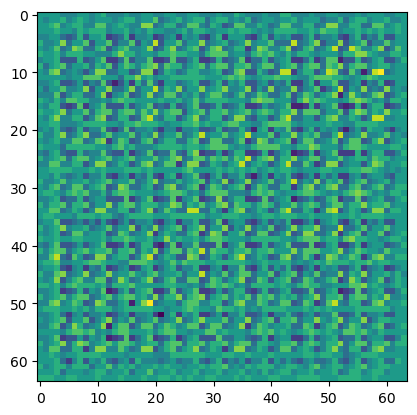

epoch = 1
Gen loss = tf.Tensor(0.026596338, shape=(), dtype=float32)Disc loss = tf.Tensor(0.036205795, shape=(), dtype=float32)
epoch = 2
Gen loss = tf.Tensor(0.028823236, shape=(), dtype=float32)Disc loss = tf.Tensor(0.03572797, shape=(), dtype=float32)
epoch = 3
Gen loss = tf.Tensor(0.027482877, shape=(), dtype=float32)Disc loss = tf.Tensor(0.039472204, shape=(), dtype=float32)
epoch = 4
Gen loss = tf.Tensor(0.02864163, shape=(), dtype=float32)Disc loss = tf.Tensor(0.037318856, shape=(), dtype=float32)
epoch = 5
Gen loss = tf.Tensor(0.026573816, shape=(), dtype=float32)Disc loss = tf.Tensor(0.041455816, shape=(), dtype=float32)
epoch = 6
Gen loss = tf.Tensor(0.026964124, shape=(), dtype=float32)Disc loss = tf.Tensor(0.038706213, shape=(), dtype=float32)
epoch = 7
Gen loss = tf.Tensor(0.037424285, shape=(), dtype=float32)Disc loss = tf.Tensor(0.026805047, shape=(), dtype=float32)
epoch = 8
Gen loss = tf.Tensor(0.044494525, shape=(), dtype=float32)Disc loss = tf.Tensor(0.019340575, sha

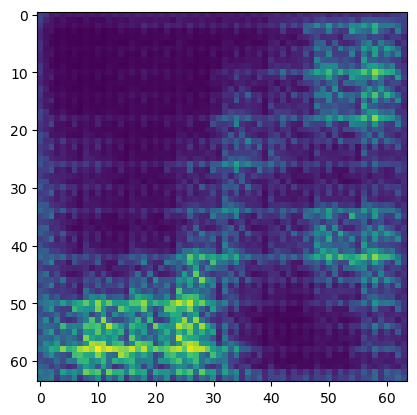

epoch = 11
Gen loss = tf.Tensor(0.020589346, shape=(), dtype=float32)Disc loss = tf.Tensor(0.058068942, shape=(), dtype=float32)
epoch = 12
Gen loss = tf.Tensor(0.019885752, shape=(), dtype=float32)Disc loss = tf.Tensor(0.056750756, shape=(), dtype=float32)
epoch = 13
Gen loss = tf.Tensor(0.025076376, shape=(), dtype=float32)Disc loss = tf.Tensor(0.044310603, shape=(), dtype=float32)
epoch = 14
Gen loss = tf.Tensor(0.02766931, shape=(), dtype=float32)Disc loss = tf.Tensor(0.040034555, shape=(), dtype=float32)
epoch = 15
Gen loss = tf.Tensor(0.02425114, shape=(), dtype=float32)Disc loss = tf.Tensor(0.047291066, shape=(), dtype=float32)
epoch = 16
Gen loss = tf.Tensor(0.025195612, shape=(), dtype=float32)Disc loss = tf.Tensor(0.04230549, shape=(), dtype=float32)
epoch = 17
Gen loss = tf.Tensor(0.025936658, shape=(), dtype=float32)Disc loss = tf.Tensor(0.041472282, shape=(), dtype=float32)
epoch = 18
Gen loss = tf.Tensor(0.022339975, shape=(), dtype=float32)Disc loss = tf.Tensor(0.0482532

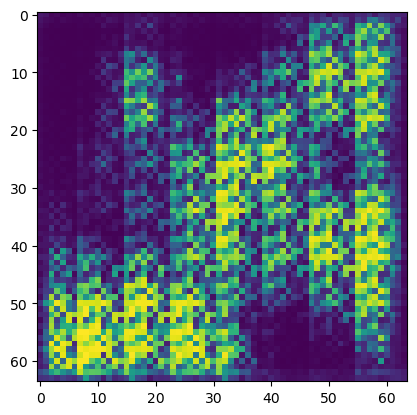

epoch = 21
Gen loss = tf.Tensor(0.024230571, shape=(), dtype=float32)Disc loss = tf.Tensor(0.043539755, shape=(), dtype=float32)
epoch = 22
Gen loss = tf.Tensor(0.023296328, shape=(), dtype=float32)Disc loss = tf.Tensor(0.0453601, shape=(), dtype=float32)
epoch = 23
Gen loss = tf.Tensor(0.022771917, shape=(), dtype=float32)Disc loss = tf.Tensor(0.043677695, shape=(), dtype=float32)
epoch = 24
Gen loss = tf.Tensor(0.022756457, shape=(), dtype=float32)Disc loss = tf.Tensor(0.041391883, shape=(), dtype=float32)
epoch = 25
Gen loss = tf.Tensor(0.021055272, shape=(), dtype=float32)Disc loss = tf.Tensor(0.043138806, shape=(), dtype=float32)
epoch = 26
Gen loss = tf.Tensor(0.021320721, shape=(), dtype=float32)Disc loss = tf.Tensor(0.045506768, shape=(), dtype=float32)
epoch = 27
Gen loss = tf.Tensor(0.019449502, shape=(), dtype=float32)Disc loss = tf.Tensor(0.05105772, shape=(), dtype=float32)
epoch = 28
Gen loss = tf.Tensor(0.020030346, shape=(), dtype=float32)Disc loss = tf.Tensor(0.0527786

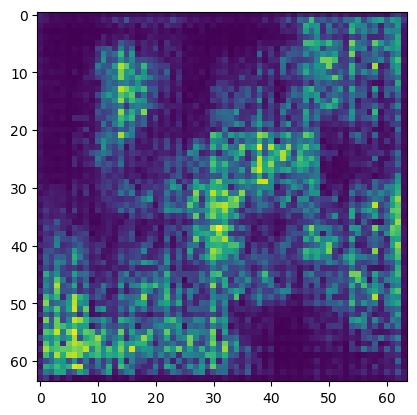

epoch = 31
Gen loss = tf.Tensor(0.020405691, shape=(), dtype=float32)Disc loss = tf.Tensor(0.050736383, shape=(), dtype=float32)
epoch = 32
Gen loss = tf.Tensor(0.018724514, shape=(), dtype=float32)Disc loss = tf.Tensor(0.052348845, shape=(), dtype=float32)
epoch = 33
Gen loss = tf.Tensor(0.019049253, shape=(), dtype=float32)Disc loss = tf.Tensor(0.050594077, shape=(), dtype=float32)
epoch = 34
Gen loss = tf.Tensor(0.019089391, shape=(), dtype=float32)Disc loss = tf.Tensor(0.05051169, shape=(), dtype=float32)
epoch = 35
Gen loss = tf.Tensor(0.019091776, shape=(), dtype=float32)Disc loss = tf.Tensor(0.051640075, shape=(), dtype=float32)
epoch = 36
Gen loss = tf.Tensor(0.020128103, shape=(), dtype=float32)Disc loss = tf.Tensor(0.050810676, shape=(), dtype=float32)
epoch = 37
Gen loss = tf.Tensor(0.019426556, shape=(), dtype=float32)Disc loss = tf.Tensor(0.05197527, shape=(), dtype=float32)
epoch = 38
Gen loss = tf.Tensor(0.019357098, shape=(), dtype=float32)Disc loss = tf.Tensor(0.050982

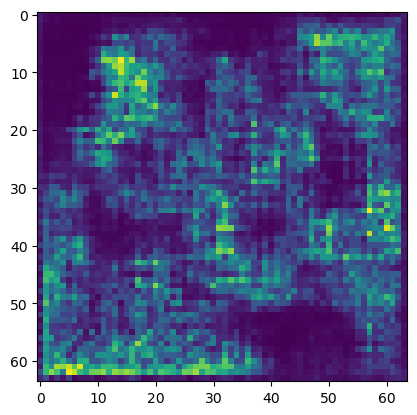

epoch = 41
Gen loss = tf.Tensor(0.01964722, shape=(), dtype=float32)Disc loss = tf.Tensor(0.050981756, shape=(), dtype=float32)
epoch = 42
Gen loss = tf.Tensor(0.02063857, shape=(), dtype=float32)Disc loss = tf.Tensor(0.049533788, shape=(), dtype=float32)
epoch = 43
Gen loss = tf.Tensor(0.020424265, shape=(), dtype=float32)Disc loss = tf.Tensor(0.049376916, shape=(), dtype=float32)
epoch = 44
Gen loss = tf.Tensor(0.019075744, shape=(), dtype=float32)Disc loss = tf.Tensor(0.050762814, shape=(), dtype=float32)
epoch = 45
Gen loss = tf.Tensor(0.02025416, shape=(), dtype=float32)Disc loss = tf.Tensor(0.049161993, shape=(), dtype=float32)
epoch = 46
Gen loss = tf.Tensor(0.02072727, shape=(), dtype=float32)Disc loss = tf.Tensor(0.049374312, shape=(), dtype=float32)
epoch = 47
Gen loss = tf.Tensor(0.020616699, shape=(), dtype=float32)Disc loss = tf.Tensor(0.0488612, shape=(), dtype=float32)
epoch = 48
Gen loss = tf.Tensor(0.020841004, shape=(), dtype=float32)Disc loss = tf.Tensor(0.048676025,

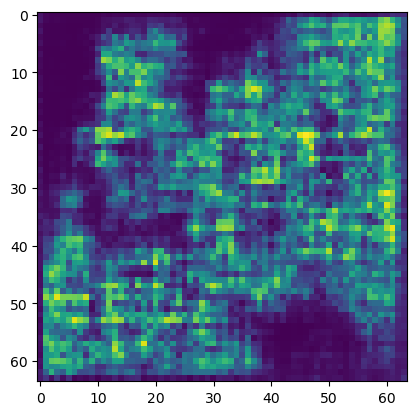

epoch = 51
Gen loss = tf.Tensor(0.021464372, shape=(), dtype=float32)Disc loss = tf.Tensor(0.048455287, shape=(), dtype=float32)
epoch = 52
Gen loss = tf.Tensor(0.021206805, shape=(), dtype=float32)Disc loss = tf.Tensor(0.048361197, shape=(), dtype=float32)
epoch = 53
Gen loss = tf.Tensor(0.021318883, shape=(), dtype=float32)Disc loss = tf.Tensor(0.048113137, shape=(), dtype=float32)
epoch = 54
Gen loss = tf.Tensor(0.021060714, shape=(), dtype=float32)Disc loss = tf.Tensor(0.048151754, shape=(), dtype=float32)
epoch = 55
Gen loss = tf.Tensor(0.021204641, shape=(), dtype=float32)Disc loss = tf.Tensor(0.04761176, shape=(), dtype=float32)
epoch = 56
Gen loss = tf.Tensor(0.02173575, shape=(), dtype=float32)Disc loss = tf.Tensor(0.047382765, shape=(), dtype=float32)
epoch = 57
Gen loss = tf.Tensor(0.021689624, shape=(), dtype=float32)Disc loss = tf.Tensor(0.04750691, shape=(), dtype=float32)
epoch = 58
Gen loss = tf.Tensor(0.02200649, shape=(), dtype=float32)Disc loss = tf.Tensor(0.04646237

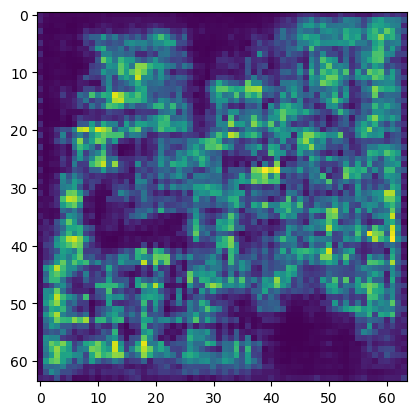

epoch = 61
Gen loss = tf.Tensor(0.0222299, shape=(), dtype=float32)Disc loss = tf.Tensor(0.045677196, shape=(), dtype=float32)
epoch = 62
Gen loss = tf.Tensor(0.022787439, shape=(), dtype=float32)Disc loss = tf.Tensor(0.045488205, shape=(), dtype=float32)
epoch = 63
Gen loss = tf.Tensor(0.021972368, shape=(), dtype=float32)Disc loss = tf.Tensor(0.045829225, shape=(), dtype=float32)
epoch = 64
Gen loss = tf.Tensor(0.022105671, shape=(), dtype=float32)Disc loss = tf.Tensor(0.045461264, shape=(), dtype=float32)
epoch = 65
Gen loss = tf.Tensor(0.022036193, shape=(), dtype=float32)Disc loss = tf.Tensor(0.045230914, shape=(), dtype=float32)
epoch = 66
Gen loss = tf.Tensor(0.022647385, shape=(), dtype=float32)Disc loss = tf.Tensor(0.04474377, shape=(), dtype=float32)
epoch = 67
Gen loss = tf.Tensor(0.022722034, shape=(), dtype=float32)Disc loss = tf.Tensor(0.04469365, shape=(), dtype=float32)
epoch = 68
Gen loss = tf.Tensor(0.022111295, shape=(), dtype=float32)Disc loss = tf.Tensor(0.04464868

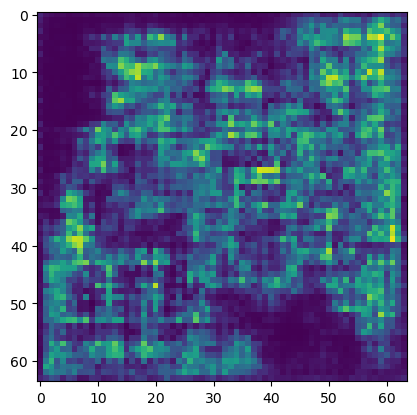

epoch = 71
Gen loss = tf.Tensor(0.023498995, shape=(), dtype=float32)Disc loss = tf.Tensor(0.043869738, shape=(), dtype=float32)
epoch = 72
Gen loss = tf.Tensor(0.025109256, shape=(), dtype=float32)Disc loss = tf.Tensor(0.043447666, shape=(), dtype=float32)
epoch = 73
Gen loss = tf.Tensor(0.022882411, shape=(), dtype=float32)Disc loss = tf.Tensor(0.043411616, shape=(), dtype=float32)
epoch = 74
Gen loss = tf.Tensor(0.022999397, shape=(), dtype=float32)Disc loss = tf.Tensor(0.041982714, shape=(), dtype=float32)
epoch = 75
Gen loss = tf.Tensor(0.026107391, shape=(), dtype=float32)Disc loss = tf.Tensor(0.04443365, shape=(), dtype=float32)
epoch = 76
Gen loss = tf.Tensor(0.030130481, shape=(), dtype=float32)Disc loss = tf.Tensor(0.03844141, shape=(), dtype=float32)
epoch = 77
Gen loss = tf.Tensor(0.020407077, shape=(), dtype=float32)Disc loss = tf.Tensor(0.044400755, shape=(), dtype=float32)
epoch = 78
Gen loss = tf.Tensor(0.024570046, shape=(), dtype=float32)Disc loss = tf.Tensor(0.041173

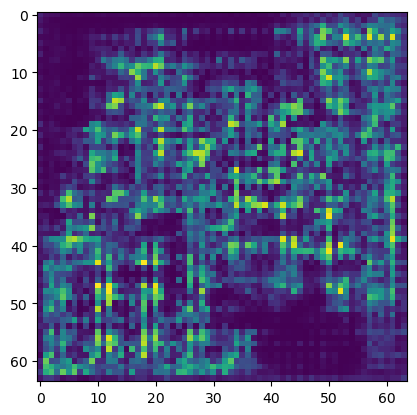

epoch = 81
Gen loss = tf.Tensor(0.021088589, shape=(), dtype=float32)Disc loss = tf.Tensor(0.04231786, shape=(), dtype=float32)
epoch = 82
Gen loss = tf.Tensor(0.0269586, shape=(), dtype=float32)Disc loss = tf.Tensor(0.042805575, shape=(), dtype=float32)
epoch = 83
Gen loss = tf.Tensor(0.031516995, shape=(), dtype=float32)Disc loss = tf.Tensor(0.03789117, shape=(), dtype=float32)
epoch = 84
Gen loss = tf.Tensor(0.022889769, shape=(), dtype=float32)Disc loss = tf.Tensor(0.039027747, shape=(), dtype=float32)
epoch = 85
Gen loss = tf.Tensor(0.025401222, shape=(), dtype=float32)Disc loss = tf.Tensor(0.039930433, shape=(), dtype=float32)
epoch = 86
Gen loss = tf.Tensor(0.028024746, shape=(), dtype=float32)Disc loss = tf.Tensor(0.042470932, shape=(), dtype=float32)
epoch = 87
Gen loss = tf.Tensor(0.024726797, shape=(), dtype=float32)Disc loss = tf.Tensor(0.03939921, shape=(), dtype=float32)
epoch = 88
Gen loss = tf.Tensor(0.023234013, shape=(), dtype=float32)Disc loss = tf.Tensor(0.039950177

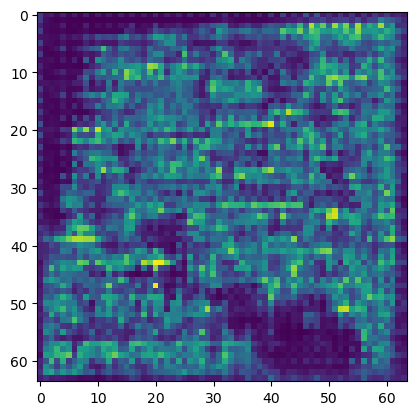

epoch = 91
Gen loss = tf.Tensor(0.025234181, shape=(), dtype=float32)Disc loss = tf.Tensor(0.040235624, shape=(), dtype=float32)
epoch = 92
Gen loss = tf.Tensor(0.025660021, shape=(), dtype=float32)Disc loss = tf.Tensor(0.039622605, shape=(), dtype=float32)
epoch = 93
Gen loss = tf.Tensor(0.023187375, shape=(), dtype=float32)Disc loss = tf.Tensor(0.03878929, shape=(), dtype=float32)
epoch = 94
Gen loss = tf.Tensor(0.025247779, shape=(), dtype=float32)Disc loss = tf.Tensor(0.037153844, shape=(), dtype=float32)
epoch = 95
Gen loss = tf.Tensor(0.031244898, shape=(), dtype=float32)Disc loss = tf.Tensor(0.04124229, shape=(), dtype=float32)
epoch = 96
Gen loss = tf.Tensor(0.032529805, shape=(), dtype=float32)Disc loss = tf.Tensor(0.033406258, shape=(), dtype=float32)
epoch = 97
Gen loss = tf.Tensor(0.027023086, shape=(), dtype=float32)Disc loss = tf.Tensor(0.035514113, shape=(), dtype=float32)
epoch = 98
Gen loss = tf.Tensor(0.0300521, shape=(), dtype=float32)Disc loss = tf.Tensor(0.04011928

In [454]:

gen_losses, disc_losses, generated_map = train(training_data, N_EPOCHS)


Denormalize, save and display generated map output

(64, 64)


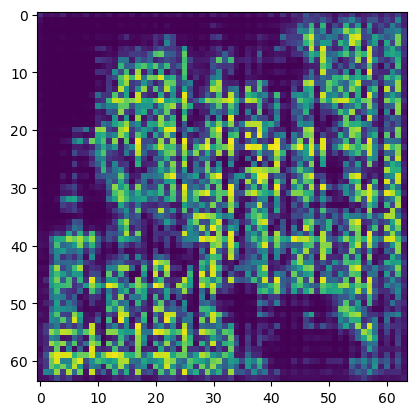

In [455]:
# denormalise generated map

generated_map *= 255

generated_map = generated_map.numpy()

generated_map = np.reshape(generated_map, (64,64))

generated_map = np.round(generated_map,0)
print(generated_map.shape)

#write generated map to csv


np.savetxt('generated_map.csv', generated_map, delimiter=',', fmt='%i')

generated_map = generated_map.tolist()


plt.imshow(generated_map)

# Graphs:

Losses

Text(0.5, 0, 'Epoch')

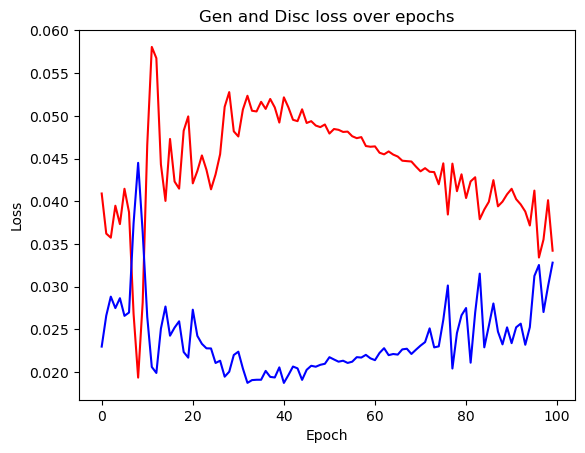

In [456]:
epoch_list = [i for i in range(0,N_EPOCHS)]


plt.plot(epoch_list, disc_losses,  'r-')
plt.plot(epoch_list, gen_losses, 'b-')
plt.title('Gen and Disc loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Discriminator Accuracy

In [457]:
plt.plot(epoch_list, disc_accuracies,  'r-')

plt.title('Disc accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

NameError: name 'disc_accuracies' is not defined